In [6]:
from tcrpeg.TCRpeg import TCRpeg
from tcrpeg.classification import classification
import pandas as pd
import numpy as np
import os
from evaluate import evaluation
from tcrpeg.utils import plotting
from tcrpeg.word2vec import word2vec
import warnings
warnings.filterwarnings('ignore')

### Load TCRs. The 'TCRs_train.csv' contains 100k TCRs randomly sampled from the universal TCR pool constructed using the 743 individual TCR repertoires from Emerson et al.

In [4]:
tcrs_train = pd.read_csv('data/TCRs_train.csv',compression='gzip')['seq'].values
tcrs_train[:3]

array(['CASSDKNYGYTF', 'CASSLAGISKDTQYF', 'CASSEDGGYNEKLFF'], dtype=object)

### Train a word2vec model to obtain the numerial embeddings for each amino acid. We also provide the pre-trained AA embeddings in the file 'data/embedding_32.txt'.

In [9]:
aa_emb = word2vec(path=tcrs_train,epochs=1,batch_size=10,device='cuda:0',lr=0.0001,window_size=2,record_path='data/your_aa_emb.txt')

100%|██████████| 603863/603863 [03:51<00:00, 2603.13it/s]

Loss at epo 1: 10.626646472600259


### Define and infer model

In [14]:
#create the TCRpeg class
model = TCRpeg(hidden_size=64,num_layers = 3,load_data=True,embedding_path='data/embedding_32.txt',path_train=tcrs_train)
#create the TCRpeg model. 
model.create_model()
#begin inferring
model.train_tcrpeg(epochs=3,batch_size=64,lr=1e-3)

  1%|▏         | 22/1562 [00:00<00:07, 219.04it/s]

Have loaded the data, total training seqs : 100000
begin the training process
begin epoch : 1


  1%|▏         | 21/1562 [00:00<00:07, 209.35it/s]

nll_loss: 22.310626796815214
begin epoch : 2


  1%|▏         | 23/1562 [00:00<00:06, 225.66it/s]

nll_loss: 19.815333586190942
The learning rate has beed reduced
begin epoch : 3


100%|██████████| 1562/1562 [00:06<00:00, 230.67it/s]

nll_loss: 19.602139205541867
The learning rate has beed reduced
Done training


### Load the plotting module and evaluation class

In [15]:
Plot = plotting()
eva = evaluation(model=model) # used for evaluate the probability inference

In [16]:
#load the test data, also randomly sampled from the test set of the universal TCR pool
test_data = pd.read_csv('data/pdf_test.csv',compression='gzip')
data = {'seq':test_data['seq'].values,'count':test_data['count'].values} 
#evaluate the inference performance
r,p_data,p_infer = eva.eva_prob(path=data)
print('The Pearson\'s correlation coefficient is: ',r)

100%|██████████| 21/21 [00:00<00:00, 67.90it/s]

Pearson correlation coefficient are : 0.8726
The Pearson's correlation coefficient is:  0.8726221136150096


### Make the inference plot

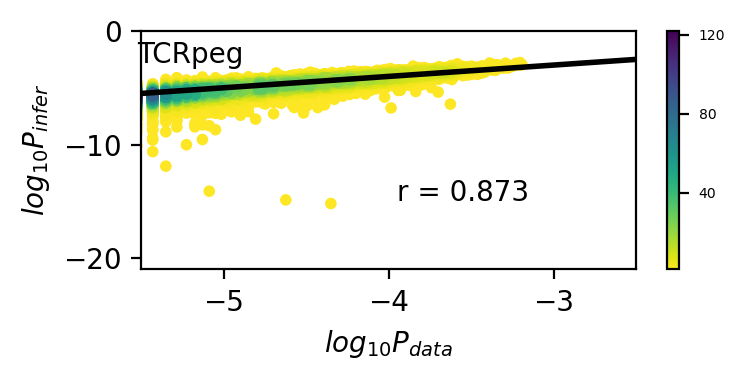

In [17]:
Plot.plot_prob(p_data,p_infer)

### Get the encodings of TCRs

In [23]:
seq_embs = model.get_embedding(tcrs_train[:100])
print(seq_embs.shape)
seq_embs[0,:][:10]

(100, 192)


array([ 0.7931774 ,  0.49157855,  0.92419696,  0.8769057 , -0.17522487,
       -0.15789196,  0.901024  ,  0.10629105,  0.4129034 ,  0.92705184],
      dtype=float32)

### Generate TCR sequences

In [18]:
gens = model.generate_tcrpeg(num_to_gen=10000,batch_size=1000) #generate TCRs batch by batch
gens[:3]

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


['CASSMTGGDYGYTF', 'CASRVTHRPYEQYF', 'CASSLELRQGPEAFF']

### Plot the distributions of length and each amino acids

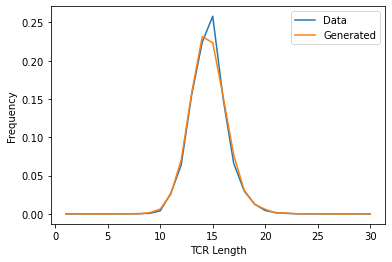

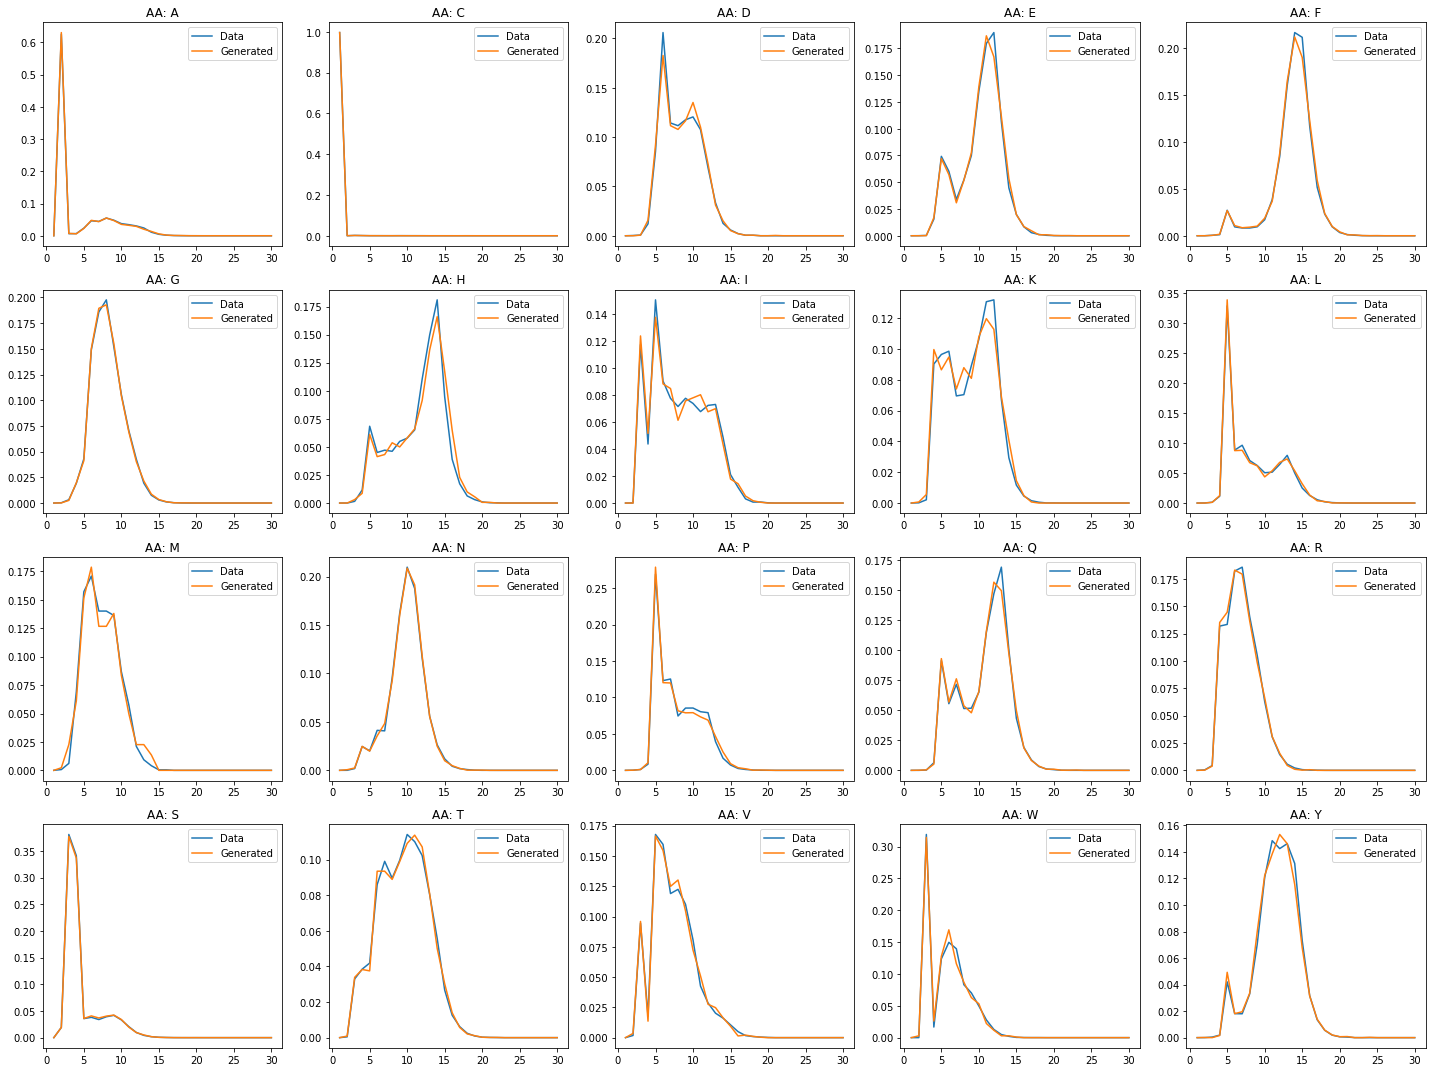

In [20]:
Plot.Length_Dis(tcrs_train,gens)
Plot.AAs_Dis(tcrs_train,gens)

### Use TCRpeg-c for classification tasks

In [24]:
#load some data; This dataset is a subset of the caTCR dataset; total seqs: 8000;
data = pd.read_csv('data/classification.csv')
x,y = list(data['seq']),list(data['label'])
#half of seqs are assigned as training/test data
x_train,y_train,x_test,y_test = x[:4000],y[:4000],x[4000:],y[4000:]

In [29]:
tcrpeg_c = classification(tcrpeg=model,embedding_size=64*3) #tcrpeg-c needs a pre-trained tcrpeg for providing emebddings
tcrpeg_c.train(x_train=x_train,y_train=y_train,epochs=3,batch_size=8,lr=1e-3,val_split=0.2)
auc,aup,y_pres,y_trues = tcrpeg_c.evaluate(x_test=x_test,y_test=y_test,batch_size=100)

  9%|▉         | 36/400 [00:00<00:01, 352.56it/s]

begin epoch : 1


  0%|          | 0/400 [00:00<?, ?it/s]

mean loss : 0.682884888201952
evaluation, avg_loss and auc is :0.6765787929296494 and 0.599
begin epoch : 2


  0%|          | 0/400 [00:00<?, ?it/s]

mean loss : 0.6725034737586975
evaluation, avg_loss and auc is :0.6714092099666595 and 0.628
The learning rate is reduced
begin epoch : 3


  0%|          | 0/40 [00:00<?, ?it/s]

mean loss : 0.6693326605856419
evaluation, avg_loss and auc is :0.6649257570505143 and 0.629
The learning rate is reduced
end training


100%|██████████| 40/40 [00:00<00:00, 533.43it/s]

evaluation, avg_loss and auc is :0.6559383660554886 and 0.654


In [30]:
print('The AUC value is: ',auc)

The AUC value is:  0.654
